# Automatic Road Network Extraction Using Satellite RGB and LiDAR Elevation

This is the "liter" version of road extraction notebook. The purpose of this version is to allow reproduction on free-tier Amazon SageMaker instances.

## Setup

[TODO] _This notebook was created and tested on an ml.p3.8xlarge notebook instance._

First of all, if you haven't done so, please follow instructions in `README.md` to run `setup-env.sh` and `download-from-s3.sh` scripts to properly set up the Conda environment and download necessary files from S3 buckets prepared for this tutorial. Before proceeding, make sure this notebook connects with the proper kernel (`conda_[name]`, `[name]` is name of the new Conda environment you just created).

In [1]:
import os, time, json, random
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import skimage
import torch
from torch import nn
import networkx as nx

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### External modules

We made some customized modification to the external module `solaris` in `libs/` directory. Please refer to their [GitHub page](https://github.com/CosmiQ/solaris) for more information.

Later in this notebook, we will also use some scripts from `APLS` for road network metric, please refer to the following pages: [APLS](https://github.com/CosmiQ/apls) and [CRESI](https://github.com/CosmiQ/cresi).

In [2]:
import libs.solaris as sol

### Plotting preferences

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

## Data

The datasets used in this notebook are saved in directory `./data/roads/`.

1. **SpaceNet satellite images**:
There are 989 tiles ("chips") of 400m$\times$400m satellite images/labels in this training dataset (`SN3/AOI_2_Vegas`). See [link](https://spacenet.ai/las-vegas/) for more information. We extract the ~0.3m resolution pan-sharpened RGB (`PS-RGB`) 3-channel satellite images and perform white balancing. The road network annotations in original SpaceNet repo are saved in directory `geojson_roads` (w/o speed annotation) and `geojson_roads_speed` (w/ speed annotation). We convert the speed graph to the following masks:
    - `mask_roads_speed` directory: multi-value mask, for visualization only
    - `mask_roads_speed_mc` directory: multi-class binary mask, for training

2. **USGS 3DEP LiDAR**:
This is [a large USGS project](https://www.usgs.gov/core-science-systems/ngp/3dep) that covers many regions throughout US. Also see [here](https://usgs.entwine.io/) for cool visualizations. We extract 3D point clouds in Las Vegas region that overlap with the SpaceNet data, project them into corresponding 2D tiles (918 in total). The LiDAR data have two attributes: elevation and reflection intensity. For road extraction, we will use the intensity attribute because road surfaces usually have different reflectivity character.

At the end, we merge the LiDAR intensity attribute as an additional channel to the RGB image, and save these 4-channel images to `RGB+INTEN/` directory.

In [4]:
data_dir = './data/roads/'
img_dir = os.path.join(data_dir, 'RGB+INTEN')
mask_dir = os.path.join(data_dir, 'mask_roads_speed')
mask_mc_dir = os.path.join(data_dir, 'mask_roads_speed_mc')

prefix = 'SN3_roads_train_AOI_2_Vegas_' # all filename prefix

If we want the network to predict speed values directly, this would be a very difficult regression + segmentation problem. Therefore, the speed values are binned to 7 categories so that the problem is now converted to a multi-class classification.

The speed conversion file `speed_conversion_binned7.csv` in `data_dir` describes the conversion stats.

In [5]:
# Road plotting parameters
speed_colors = [36, 72, 108, 144, 180, 216, 252]
road_mask_params = {'vmin': 0, 'vmax': 255, 'cmap': 'YlOrRd', 'interpolation': 'none'}

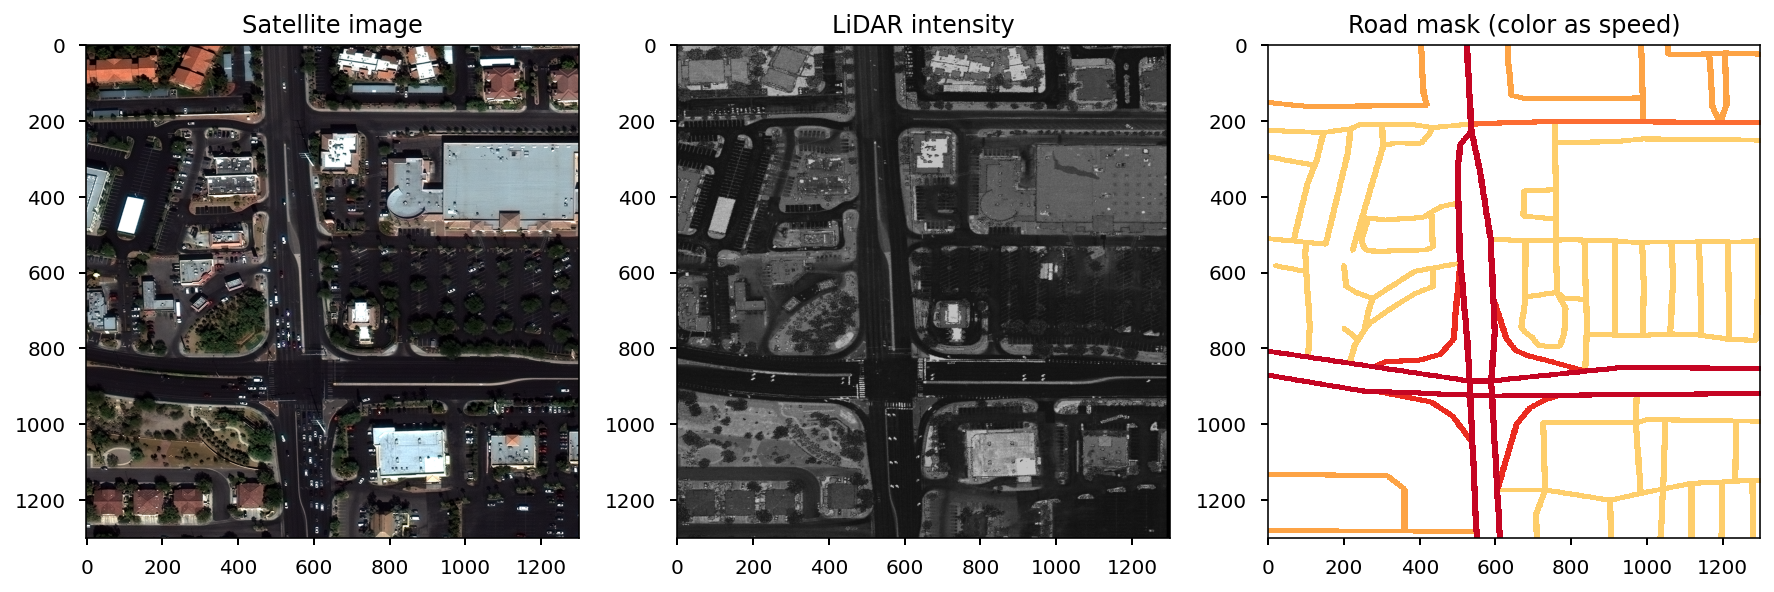

In [6]:
# Show a data sample
sample = 'img432' # chip ID, img? format

# Read in 4-channel image from GeoTIFF.
img_file = prefix + 'RGB+INTEN_' + sample + '.tif'
img_path = os.path.join(img_dir, img_file)
img = skimage.io.imread(img_path)
rgb = img[..., :3]
inten = img[..., -1]

# Read in road mask images. Note that these masks were binned
# into multiple speed bins. In this case, there are 7 categories.
mask_file = img_file.replace('RGB+INTEN', 'mask_roads_speed')
mask_path = os.path.join(mask_dir, mask_file)
mask = skimage.io.imread(mask_path)

# Display satellite image and road mask.
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.05, hspace=0.05)
ax[0].imshow(rgb)
# ax[0].axis('off')
ax[0].set_title('Satellite image')
ax[1].imshow(inten, cmap='gray', vmin=0, vmax=5000)
ax[1].set_title('LiDAR intensity')
ax[2].imshow(mask, alpha=(mask>0).astype('float'), **road_mask_params)
# plt.setp(ax[1].get_yticklabels(), visible=False)
# plt.setp(ax[1].get_xticklabels(), visible=False)
# ax[1].tick_params(axis='both', which='both', length=0)
ax[2].set_title('Road mask (color as speed)')
fig.show()

### Multi-class binary mask

In the above figure, the mask is multi-valued (0-7). This is good for visualization, however, tricky for network training. We will use another type of mask: multi-class binary mask shown below. Besides 7 binary masks corresponding to 7 speed bins, an aggregated mask is appended as the 8th label channel.

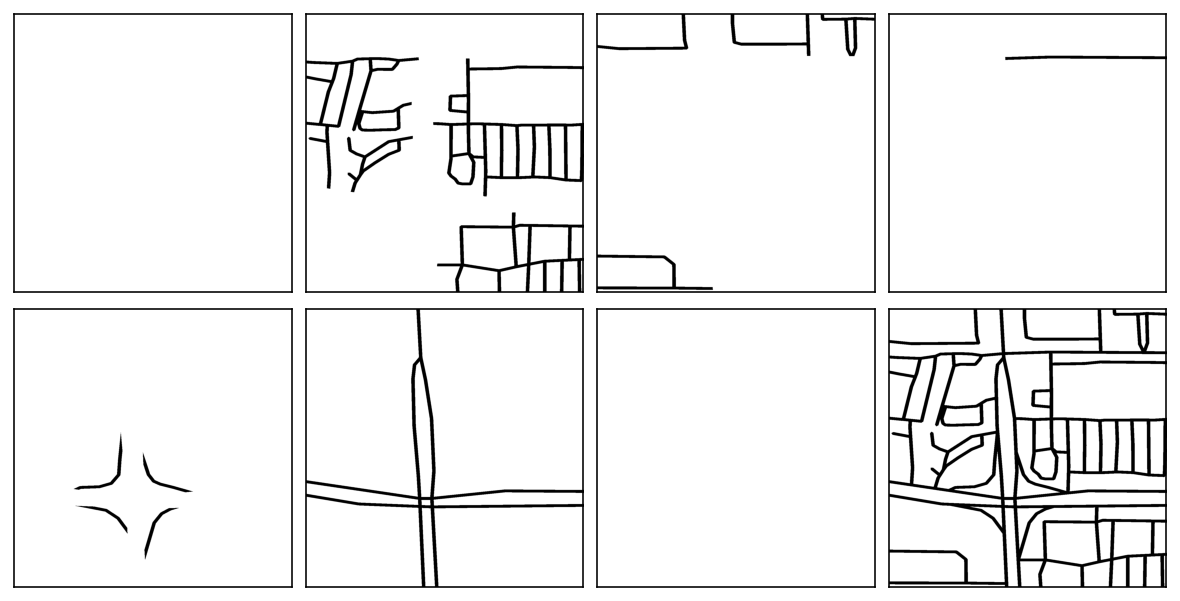

In [7]:
mask_mc_file = img_file.replace('RGB+INTEN', 'mask_roads_speed_mc')
mask_mc_path = os.path.join(mask_mc_dir, mask_mc_file)
mask_mc = skimage.io.imread(mask_mc_path)

fig, ax = plt.subplots(2, 4, figsize=(8, 4))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.05, hspace=0.05)
for i in range(mask_mc.shape[-1]):
    row = i // ax.shape[-1]
    col = i % ax.shape[-1]
    subax = ax[row][col]
    
    submask = mask_mc[..., i]
    subax.imshow(submask, cmap='gray_r')
    
    plt.setp(subax.get_yticklabels(), visible=False)
    plt.setp(subax.get_xticklabels(), visible=False)
    subax.tick_params(axis='both', which='both', length=0)
fig.show()

## Inference on sample data

For this notebook, all training setups in `.yml` format are saved in directory `configs/roads/`:
1. `RGB-only.yml`: network only uses RGB images as input (3-channel);
2. `INTEN-only.yml`: network only uses LiDAR intensity images as input (1-channel);
3. `RGB+INTEN.yml`: network uses both RGB and LiDAR intensity as merged input (4-channel).

In the following cell, please select the config file you would like to experiment. After completing this notebook, feel free to come back here, change to other config or create your own setup to see what's different.

In [8]:
# --------------------------------------------#
# Select the config file you want to use
config = sol.utils.config.parse('./configs/roads/RGB+INTEN.yml')
# --------------------------------------------#

Next, let's load a customized ResNet-Unet from `networks/` directory. This algorithm is used in the SpaceNet road extraction benchmark [CRESI](https://github.com/CosmiQ/cresi). We modified the code so that it takes multi-channel input.

In [9]:
# Load customized multi-channel input ResNet-Unet model.
from networks.resnet_unet import get_modified_resnet_unet

custom_model = get_modified_resnet_unet(
    in_channels=config['data_specs']['channels'], logits=False
) # Output sigmoid (0-1 value)
custom_model_dict = {
    'model_name': 'modified_resnet_unet',
    'weight_path': config['training']['model_dest_path'],
    'weight_url': None,
    'arch': custom_model
}
config['train'] = False
inferer = sol.nets.infer.Inferer(config, custom_model_dict=custom_model_dict)

sample_df = pd.DataFrame({'image': [img_path]}) # previous sample image
inferer(sample_df)

100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


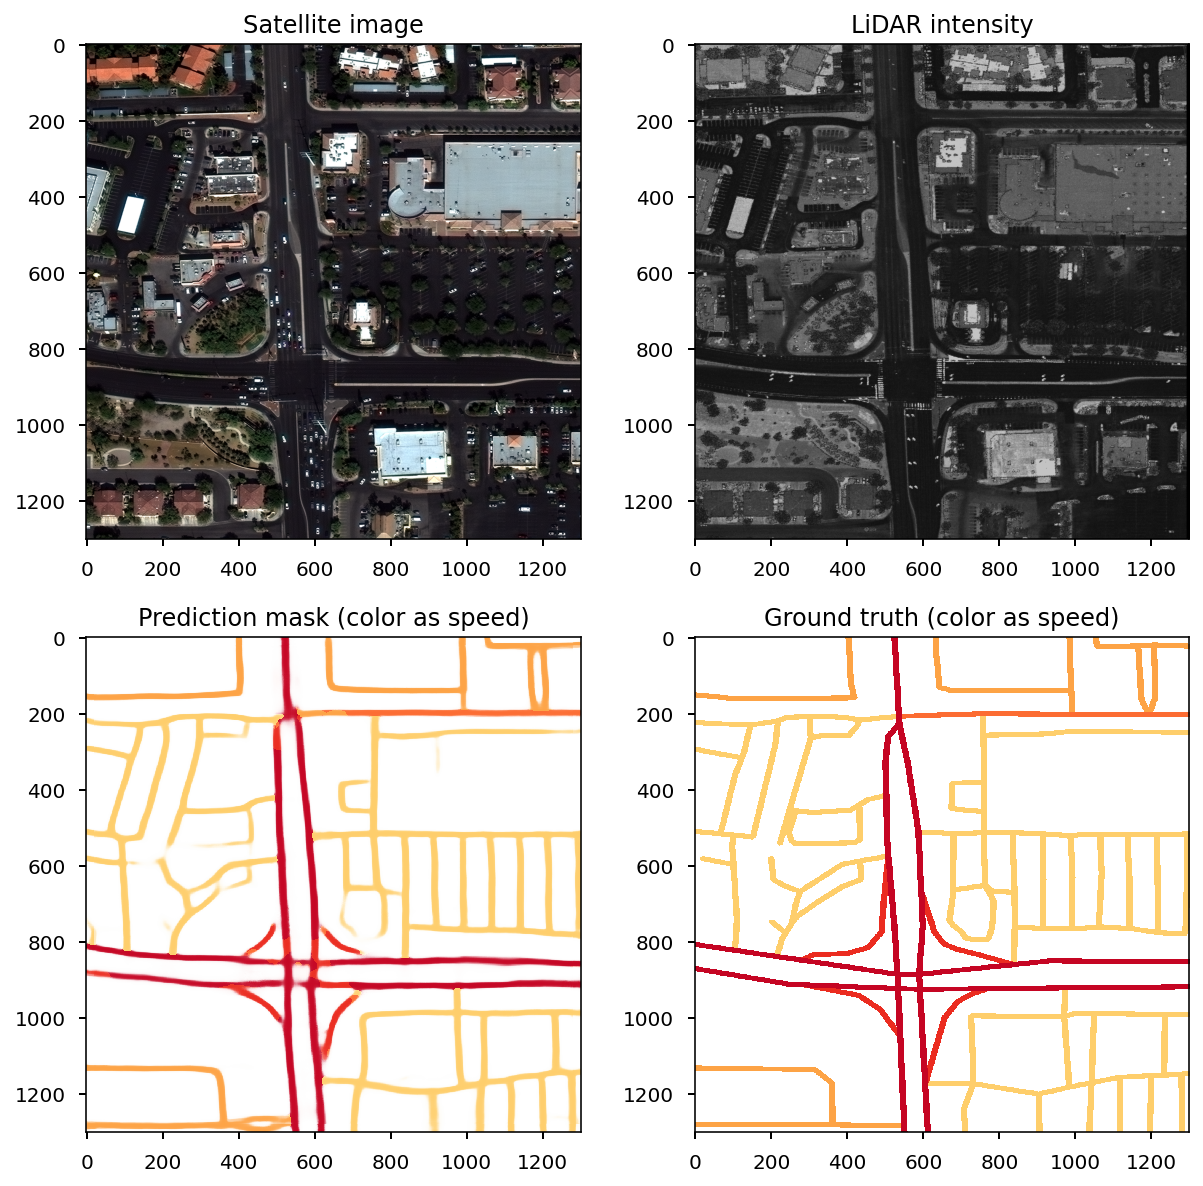

In [10]:
# Load prediction result from the output directory
pred_file = img_file # same name as input image file
pred_dir = config['inference']['output_dir']
pred_path = os.path.join(pred_dir, pred_file)
pred = skimage.io.imread(pred_path)

# Prepare for multi-class visualization
pred_class = np.argmax(pred[..., :-1], axis=-1) # discard the last aggregated channel
pred_color = np.array(speed_colors)[pred_class]
pred_alpha = pred[..., -1] # aggregated likelihood as alpha

# Display satellite image, LiDAR, prediction mask, and ground truth mask.
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(rgb)
ax[0][0].set_title('Satellite image')
ax[0][1].imshow(inten, cmap='gray', vmin=0, vmax=5000)
ax[0][1].set_title('LiDAR intensity')
ax[1][0].imshow(pred_color, alpha=pred_alpha, **road_mask_params)
ax[1][0].set_title('Prediction mask (color as speed)')
ax[1][1].imshow(mask, alpha=(mask>0).astype('float'), **road_mask_params)
ax[1][1].set_title('Ground truth (color as speed)')
fig.show()

## Graph extraction and scoring

Based on the prediction mask, we can extract the skeleton of the road and build the road graph with APLS toolkit. [APLS](https://github.com/CosmiQ/apls) is a metric system specifically designed for road topology by SpaceNet project owner. We made some modification to the scripts and put them in `./libs/apls/` directory.

In this section, we will go through this process and get the scores for the test result above.

In [11]:
results_dir = Path(pred_dir).parent

# Skeletonize the prediction mask into non-geo road network graph.
!python ./libs/apls/skeletonize.py --results_dir={results_dir}
# Match geospatial info and create geo-projected graph.
!python ./libs/apls/wkt_to_G.py --imgs_dir={img_dir} --results_dir={results_dir}
# Infer road speed on each graph edge based on speed bins.
!python ./libs/apls/infer_speed.py --results_dir={results_dir} \
    --speed_conversion_csv_file='./data/roads/speed_conversion_binned7.csv'

Running in parallel using all threads ...
100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.49it/s]
Graph gpickle dir:  results/roads/RGB+INTEN/skeleton_gpickle
WKT csv file:  results/roads/RGB+INTEN/wkt_nospeed.csv
Number of lines:  243
Total time to built skeleton WKT:   3.06 s
Using all thread(s) to process 7 non-empty graphs ...
100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.11it/s]
Graph gpickle dir:  results/roads/RGB+INTEN/graph_nospeed_gpickle
Time to run wkt_to_G.py:   3.52 s
Running in parallel using all threads ...
100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  5.88it/s]
Graph gpickle dir:  results/roads/RGB+INTEN/graph_speed_gpickle
Time to run speed infer:   1.72 s


### Visualize the speed graph

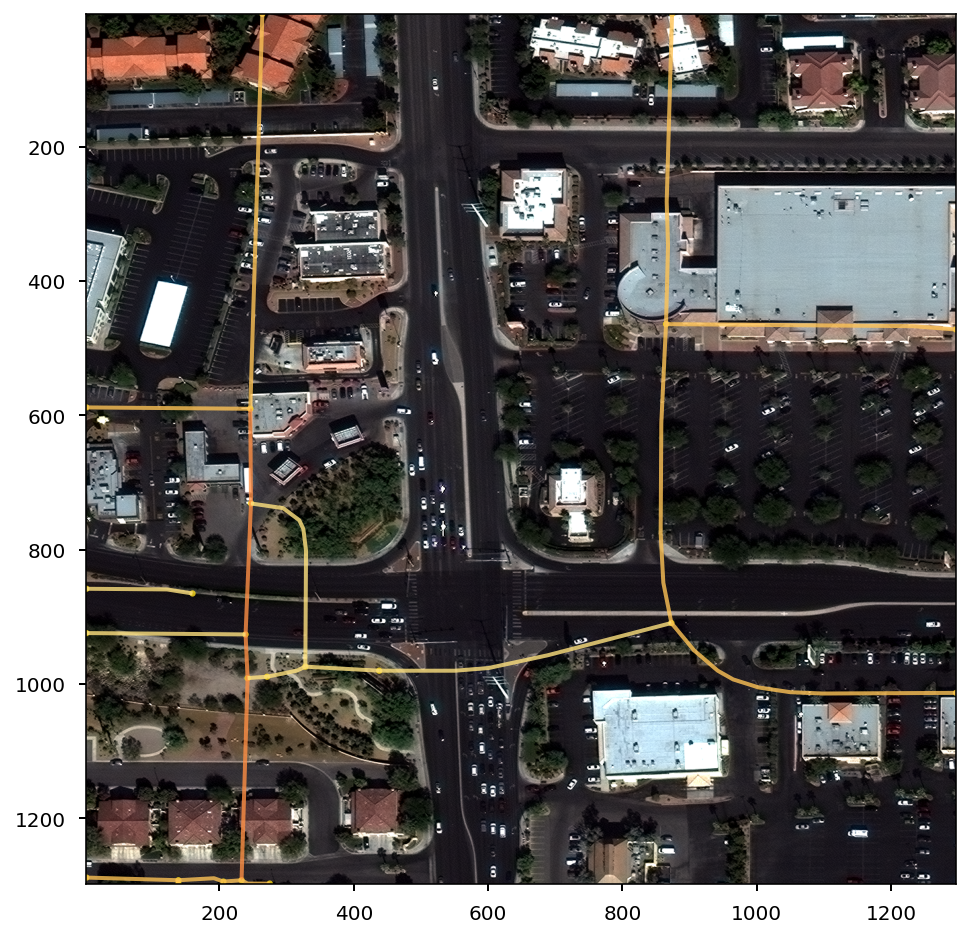

In [12]:
from libs.apls.plot_road import plot_graph, plot_route, make_color_dict_list

color_dict, _ = make_color_dict_list()
graph_speed_dir = os.path.join(results_dir, 'graph_speed_gpickle')
G_file = [f for f in os.listdir(graph_speed_dir) if f.endswith('.gpickle')][0]
G_path = os.path.join(graph_speed_dir, G_file)
G = nx.read_gpickle(G_path)

# Plot settings
graph_params = {
    'fig_height': 8,
    'fig_width': 8,
    'margin': 0.0,
    'axis_off': False,
    'node_color': '#ffdd1a',
    'node_size': 10,
    'node_alpha': 0.8,
    'edge_color': '#ffdd1a',
    'edge_linewidth': 2,
    'edge_alpha': 0.8,
    'edge_color_key': 'inferred_speed_mph',
    'color_dict': color_dict
}

fig, ax = plot_graph(G, im=rgb, **graph_params)
fig.show()

### Simulate navigation between random points

With the road network graph available, we can simulate navigation between 2 random points (source and target) in the test image. In the following figure, you'll see two different results, one minimizing path length and another minimizing travel time (path length weighted by travel speed).

Note: sometimes, there may be no path linking the source and target; in that case, simply rerun the following cell until it shows valid paths.

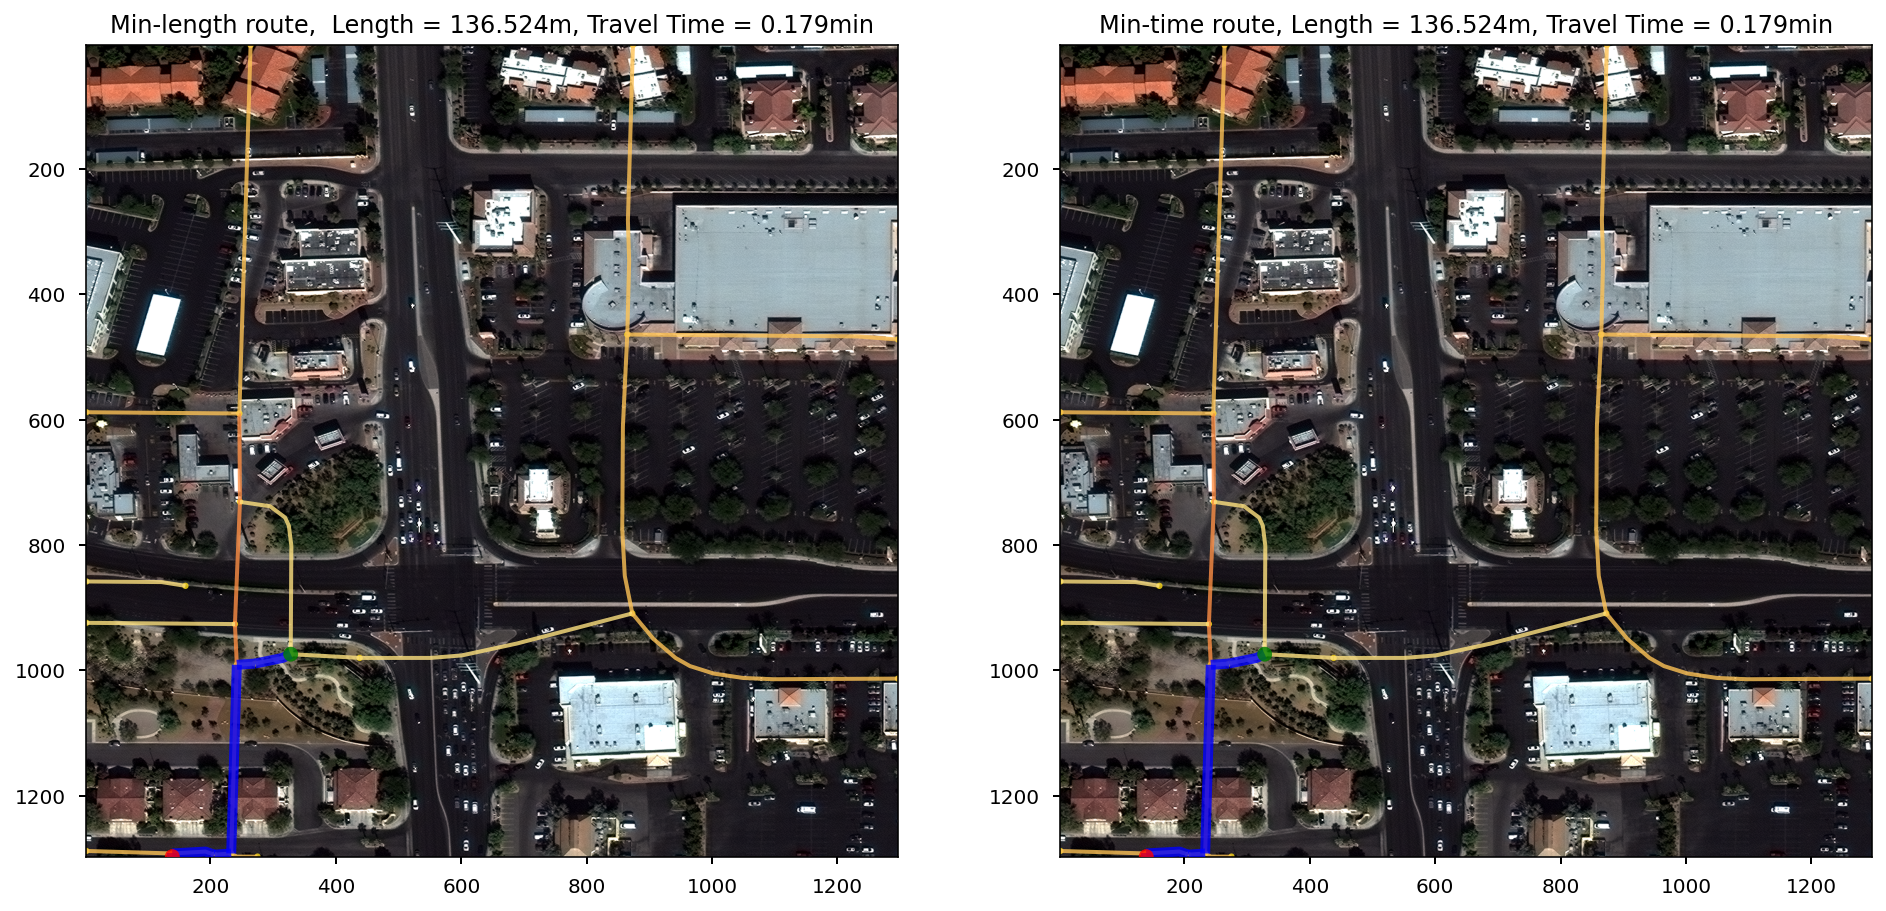

In [13]:
all_nodes = list(G.nodes())
# Random select nodes. Sometimes may fail!
source = random.choice(all_nodes)
target = random.choice(all_nodes)

l, route_l = nx.single_source_dijkstra(
    G, source=source, target=target, weight='length'
)
t_l = sum([
        G[route_l[i]][route_l[i+1]][0]['Travel Time (h)']
        for i in range(len(route_l)-1)
])
t_l *= 60 # convert h to min

t, route_t = nx.single_source_dijkstra(
    G, source=source, target=target, weight='Travel Time (h)'
)
t *= 60 # convert h to min
l_t = sum([
        G[route_t[i]][route_t[i+1]][0]['length']
        for i in range(len(route_t)-1)
])

# Plot side-by-side
fig, (ax_l, ax_t) = plt.subplots(ncols=2, figsize=(16, 8))
color_dict, _ = make_color_dict_list()
fig, ax_l = plot_graph(G, im=rgb, **graph_params, fig=fig, ax=ax_l)
fig, ax_t = plot_graph(G, im=rgb, **graph_params, fig=fig, ax=ax_t)

route_params = {
    'origin_node': source,
    'destination_node': target,
    'orig_dest_node_size': 50,
    'orig_dest_node_color': ('g', 'r'),
    'orig_dest_node_alpha': 0.8,
    'route_color': 'b',
    'route_linewidth': 5,
    'route_alpha': 0.8}
fig, ax_l = plot_route(G, route_l, **route_params, fig=fig, ax=ax_l)
ax_l.set_title(
    "Min-length route,  Length = {:.3f}m, Travel Time = {:.3f}min".format(l, t_l)
)
fig, ax_t = plot_route(G, route_t, **route_params, fig=fig, ax=ax_t)
ax_t.set_title(
    "Min-time route, Length = {:.3f}m, Travel Time = {:.3f}min".format(l_t, t)
)

fig.show()

### Scoring

Similarly, APLS will generate two scores, one weighted by length and another by travel time. The APLS$_{length}$ is similar to the scoring metric in SpaceNet challenge 3, and APLS$_{time}$ is the official scoring metric in SpaceNet challenge 5.

In [14]:
# Compute length-based APLS score.
!python ./libs/apls/apls.py --output_dir={results_dir} \
    --truth_dir={os.path.join(data_dir, 'geojson_roads_speed')} \
    --im_dir={img_dir} \
    --prop_dir={os.path.join(results_dir, 'graph_speed_gpickle')} \
    --weight='length'

# Compute time-based APLS score.
!python ./libs/apls/apls.py --output_dir={results_dir} \
    --truth_dir={os.path.join(data_dir, 'geojson_roads_speed')} \
    --im_dir={img_dir} \
    --prop_dir={os.path.join(results_dir, 'graph_speed_gpickle')} \
    --weight='travel_time_s'

Checking valid scoring pairs from 981 ground truths ...
Running in parallel using all threads ...
100%|████████████████████████████████████████| 981/981 [00:03<00:00, 276.91it/s]
Computing scores for 7 pairs in total ...
Running in parallel using all threads ...
100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.09it/s]
Weight is length
Mean APLS =  0.6334297339039211
Checking valid scoring pairs from 981 ground truths ...
Running in parallel using all threads ...
100%|████████████████████████████████████████| 981/981 [00:03<00:00, 282.74it/s]
Computing scores for 7 pairs in total ...
Running in parallel using all threads ...
100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]
Weight is travel_time_s
Mean APLS =  0.5865501933354462


## Infer on Random Image

In this section, we visually check some results. The next cell randomly sample from the result list. Rerun as many times as you wish to see different figures.

You may also insert cells from previous section "Graph extraction and scoring" to plot the graph and navigation paths.

In [15]:
# Get list of available images.
img_file_list = [f for f in os.listdir(img_dir) if f.endswith('.tif')]
img_file_list.sort()

100%|██████████| 1/1 [00:04<00:00,  4.18s/it]


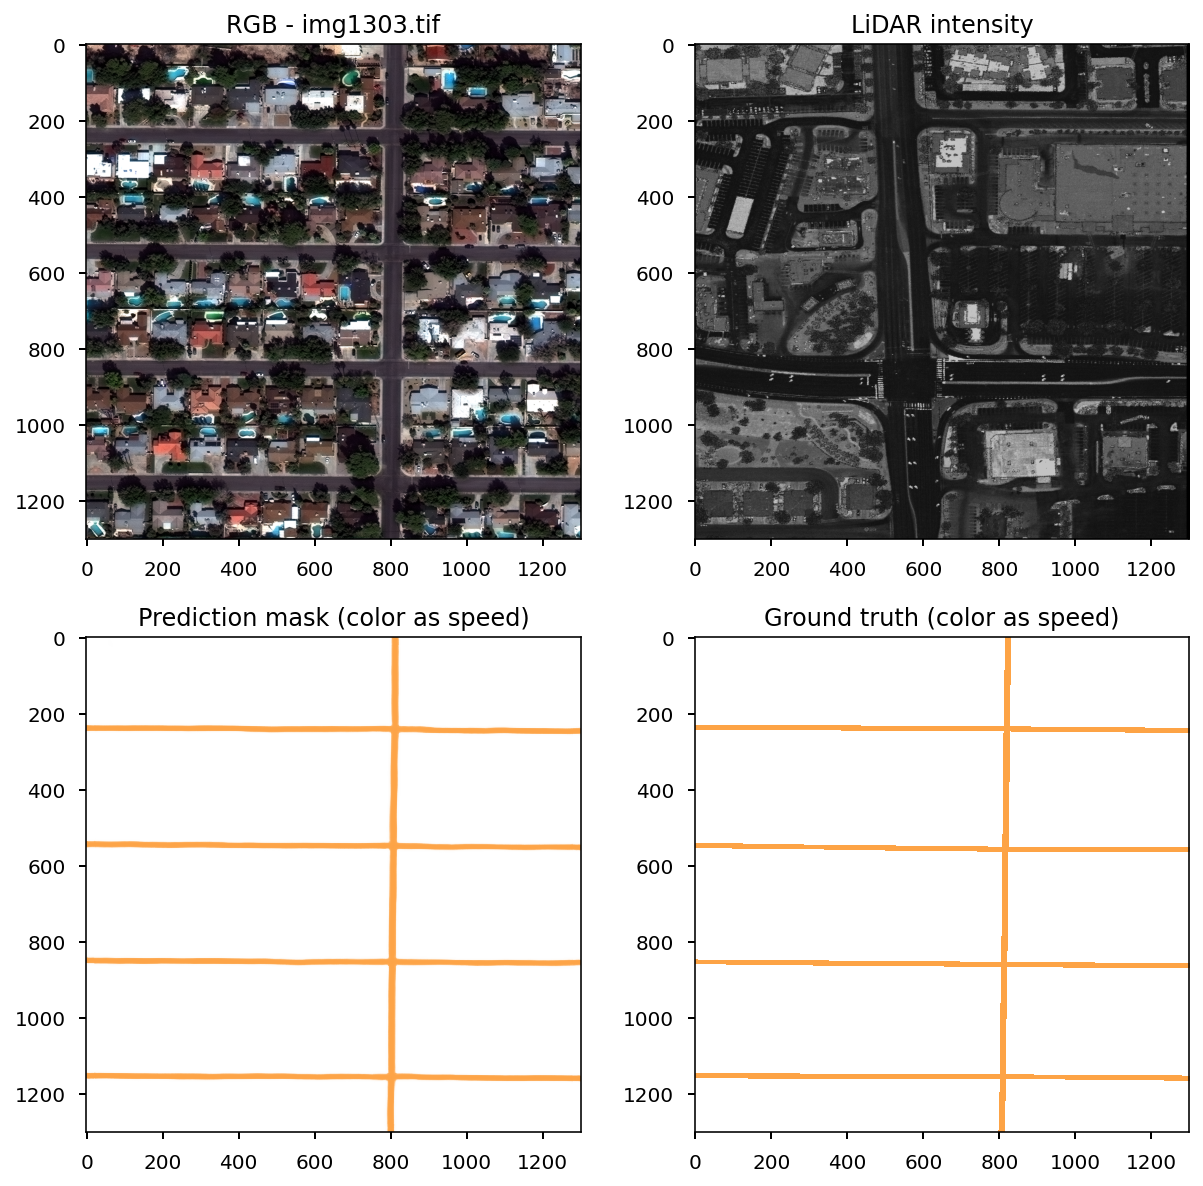

In [16]:
# Randomly check the network predictions. Feel free to rerun this cell!
file = random.choice(img_file_list)
# Or you can select the 'img432.tif' we saw before.
# file = 'SN3_roads_train_AOI_2_Vegas_RGB+INTEN_img1574.tif'
img_path = os.path.join(img_dir, file)
pred_path = os.path.join(pred_dir, file)
mask_path = os.path.join(mask_dir, file.replace('RGB+INTEN', 'mask_roads_speed'))
                         
# Perform one-time inference on the selected image.
infer_df = pd.DataFrame({'image': [img_path]})
inferer(infer_df)

# Visualize the result.
img = skimage.io.imread(img_path)
rgb = img[..., :3]
elev = img[..., -1]
pred = skimage.io.imread(pred_path)
mask = skimage.io.imread(mask_path)

# Prepare for multi-class visualization
pred_class = np.argmax(pred[..., :-1], axis=-1) # discard the last aggregated channel
pred_color = np.array(speed_colors)[pred_class]
pred_alpha = pred[..., -1] # aggregated likelihood as alpha

# Display satellite image, LiDAR, prediction mask, and ground truth mask.
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(rgb)
ax[0][0].set_title('RGB - {}'.format(file.split('_')[-1]))
ax[0][1].imshow(inten, cmap='gray', vmin=0, vmax=5000)
ax[0][1].set_title('LiDAR intensity')
ax[1][0].imshow(pred_color, alpha=pred_alpha, **road_mask_params)
ax[1][0].set_title('Prediction mask (color as speed)')
ax[1][1].imshow(mask, alpha=(mask>0).astype('float'), **road_mask_params)
ax[1][1].set_title('Ground truth (color as speed)')
fig.show()